# Dataset Statistics/exploration

Try to understand the quality of the data better

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)   # go one level up
print(os.getcwd())            # check
from functools import partial
from xflow import SqlProvider, pipe_each, TransformRegistry as T
from xflow.utils import plot_image
import xflow.extensions.physics
from config_utils import load_config, detect_machine
from utils import *

experiment_name = "CAE_validate_clear"  
machine = detect_machine() 

config = load_config(
    f"{experiment_name}.yaml",
    machine=machine
)

c:\Users\qiyuanxu\Documents\GitHub\fiber-image-reconstruction-comparison
[config_utils] Using machine profile: win-qiyuanxu


In [2]:
# Connect to database and read image sample paths
"""wednesday chromox"""
test_dir = config["paths"]["chromox_01"] 
db_path = f"{test_dir}/db/dataset_meta.db"
query = """
SELECT 
    image_path
FROM mmf_dataset_metadata 
WHERE batch IN (10, 11, 12)
--LIMIT 20
"""
realbeam_provider = SqlProvider(
    sources={"connection": db_path, "sql": query}, output_config={'list': "image_path"}
)
image_paths = realbeam_provider()

--------------------------------------------------------------------------------
Connected to SQLite database with 3 tables
--------------------------------------------------------------------------------


In [8]:
from xflow.extensions.physics.beam import extract_beam_parameters

# Processing data
params = {
    "crop_gt": [[83, 178], [160, 101]],
    "crop_fo": [[0, 0], [255, 255]],
    "inp_size": (256, 256),
    "out_size": (256, 256),
}

results = list(pipe_each(
    image_paths,
    partial(T.get("add_parent_dir"), parent_dir=test_dir),
    T.get("torch_load_image"),
    T.get("torch_to_tensor"),
    T.get("torch_to_grayscale"),
    T.get("torch_remap_range"),
    partial(T.get("torch_split_width"), swap=True),  # returns (fiber_output, ground_truth)
    # [None, partial(T.get("check_centroid"), rect=params["crop_gt"], method="first_moment", on_fail="raise")], # identity for fiber_output
    [partial(T.get("torch_crop_area"), points=params["crop_fo"]), partial(T.get("torch_crop_area"), points=params["crop_gt"])],
    [partial(T.get("torch_resize"), size=params["inp_size"]), partial(T.get("torch_resize"), size=params["out_size"])],
    #[None, partial(T.get("apply"), fn=extract_beam_parameters)],
    progress=True,
    desc="Processing images",
    skip_errors=False
))

Processing images: 100%|██████████| 2627/2627 [00:06<00:00, 381.02it/s]


In [7]:
results

[(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  None),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  None),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  None),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

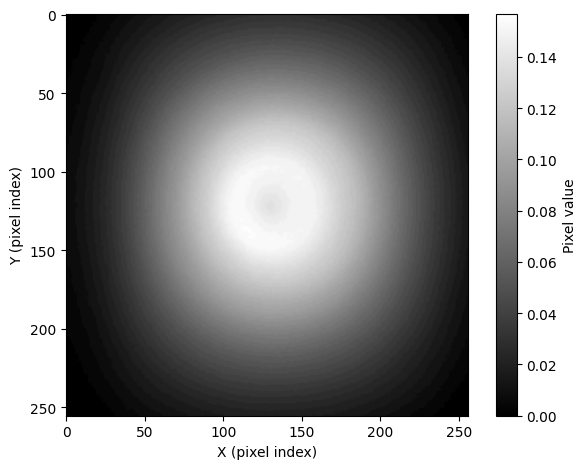

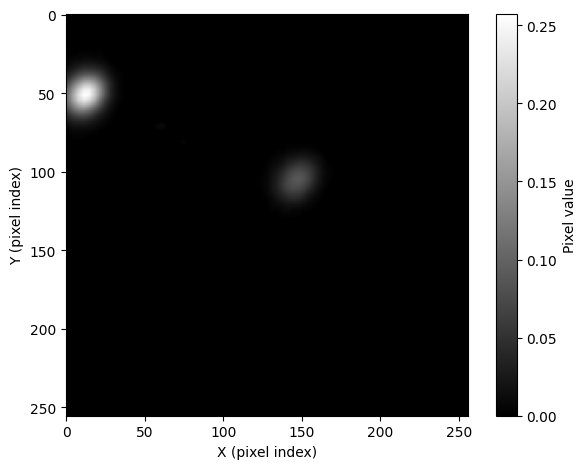

In [9]:
# data check up

plot_image(results[0][0])
plot_image(results[0][1])